In [ ]:
# Imports 
import torch
from PIL import Image 
from torchvision import transforms
import torchvision
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score as sk_accuracy
from torch.utils.data import Dataset
from torchvision import transforms
import glob 
import os 
from torch.utils.data import DataLoader 
from torch import nn
from torch.nn import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50 
from torch.utils.data import random_split
import numpy as np
import sklearn
import matplotlib.pyplot as plt


In [ ]:
# TODO: Save in drive? 
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Expert.zip
!unzip Expert.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Radiographs.zip
!unzip Radiographs.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Student.zip
!unzip Student.zip
!wget http://tdd.ece.tufts.edu/Tufts_Dental_Database/Segmentation.zip
!unzip Segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Student/gaze_map/gray/1021.JPG  
  inflating: Student/gaze_map/gray/1024.JPG  
  inflating: Student/gaze_map/gray/1025.JPG  
  inflating: Student/gaze_map/gray/1027.JPG  
  inflating: Student/gaze_map/gray/1028.JPG  
  inflating: Student/gaze_map/gray/103.JPG  
  inflating: Student/gaze_map/gray/1030.JPG  
  inflating: Student/gaze_map/gray/1031.JPG  
  inflating: Student/gaze_map/gray/1032.JPG  
  inflating: Student/gaze_map/gray/1034.JPG  
  inflating: Student/gaze_map/gray/1035.JPG  
  inflating: Student/gaze_map/gray/1036.JPG  
  inflating: Student/gaze_map/gray/1037.JPG  
  inflating: Student/gaze_map/gray/1038.JPG  
  inflating: Student/gaze_map/gray/1039.JPG  
  inflating: Student/gaze_map/gray/104.JPG  
  inflating: Student/gaze_map/gray/1040.JPG  
  inflating: Student/gaze_map/gray/1041.JPG  
  inflating: Student/gaze_map/gray/1042.JPG  
  inflating: Student/gaze_map/gray/1043.JPG  
  inflating: Student/gaze_map/g

In [ ]:
# Uncomment to use gpu
torch.cuda.set_device('cuda:0')

## Dataset

In [ ]:
img_size = (260, 400)

In [ ]:
import json
# Create Dataset to easily load data from files. 
# Radiograph transforms -- extra transforms to apply to radiograph tensor
# mask_transform -- extra transforms to apply to mask tensor 
class MaskDataset(Dataset):
  def __init__(self, radiograph_transform = None, mask_transform = None, path = ''):
    if radiograph_transform is not None: 
      self.radiograph_transform = transforms.Compose([
           transforms.ToTensor(),
           radiograph_transform
      ])
    else: 
      self.radiograph_transform = transforms.Compose((
          transforms.ToTensor(),
          transforms.Resize(img_size)
      ))

    if mask_transform is not None:
      self.mask_transform = transforms.Compose([
          transforms.ToTensor(),
          mask_transform
      ])
    else:
      self.mask_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(img_size)
      ])

    
    self.path = path
    files = glob.glob(self.path + 'Radiographs/*')
    self.files = [(x.split('/')[1]).lower() for x in files]

    print(self.files)
    with open(self.path + 'Expert/expert.json', 'r') as f:
      metadata = json.load(f)
    self.metadata = {}
    for img_metadata in metadata:
      # Make it easy to query by ID 
      key = img_metadata['External ID']
      self.metadata[key] = img_metadata
      # Add tag if it has abnormality or not 
      objects = img_metadata['Label']['objects']
      # TODO: Remove if we want objects 
      del img_metadata['Label']
      self.metadata[key]['abnormality_exists'] = not (len(objects) == 1 and objects[0]['title'] == "None")

  def _to_deeplab(self, mask):
    mask = self.mask_transform(mask)[0].to(torch.int64)
    return torch.nn.functional.one_hot(mask, num_classes = 2).permute((2, 0, 1)).float()

  def __getitem__(self, idx):
    radiograph = Image.open(self.path + 'Radiographs/' + self.files[idx].upper())
    teeth_mask = Image.open(self.path + 'Segmentation/teeth_mask/' + self.files[idx].lower())
    abnormality_mask = Image.open(self.path + 'Expert/mask/' + self.files[idx].upper())

    radiograph = self.radiograph_transform(radiograph)

    # Format deeplab expects
    # All mask channels are the same
    teeth_mask = self._to_deeplab(teeth_mask)
    abnormality_mask = self._to_deeplab(abnormality_mask)

    img_metadata = self.metadata[self.files[idx].upper()]

    label = torch.tensor(img_metadata['abnormality_exists']).to(torch.int64)
    label = torch.nn.functional.one_hot(label, num_classes = 2)

    # NOTE: These both have three channels, but all channels have same value (greyscale)
    return {'radiograph' : radiograph, 'teeth_mask' : teeth_mask,
            'abnormality_mask': abnormality_mask,
            'metadata' : img_metadata,
            'label': label}
    
  
  def __len__(self):
    return len(self.files)

In [ ]:

# Data augmentation for radiographs
# Gaussian smoothing, random adjust sharpness and random autocontrast
radiograph_transforms = transforms.Compose([
   transforms.Resize(img_size),                                      
  #  transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5)),
  #  transforms.RandomAdjustSharpness(sharpness_factor=1.1, p=0.5),
  #  transforms.RandomAutocontrast(p=0.5),
  transforms.RandomHorizontalFlip(p=0.5),
   # transforms.RandomCrop((220, 360))
   ]
)


In [ ]:
dataset = MaskDataset(radiograph_transform=radiograph_transforms)

['952.jpg', '662.jpg', '1027.jpg', '886.jpg', '472.jpg', '26.jpg', '848.jpg', '263.jpg', '211.jpg', '737.jpg', '566.jpg', '879.jpg', '398.jpg', '729.jpg', '712.jpg', '507.jpg', '269.jpg', '484.jpg', '918.jpg', '544.jpg', '773.jpg', '548.jpg', '338.jpg', '565.jpg', '114.jpg', '293.jpg', '528.jpg', '987.jpg', '803.jpg', '937.jpg', '730.jpg', '453.jpg', '126.jpg', '234.jpg', '562.jpg', '1044.jpg', '547.jpg', '232.jpg', '321.jpg', '816.jpg', '558.jpg', '844.jpg', '824.jpg', '205.jpg', '37.jpg', '913.jpg', '373.jpg', '1039.jpg', '617.jpg', '627.jpg', '710.jpg', '442.jpg', '673.jpg', '784.jpg', '464.jpg', '486.jpg', '117.jpg', '56.jpg', '726.jpg', '511.jpg', '495.jpg', '894.jpg', '185.jpg', '78.jpg', '189.jpg', '422.jpg', '119.jpg', '649.jpg', '461.jpg', '577.jpg', '36.jpg', '871.jpg', '733.jpg', '42.jpg', '555.jpg', '382.jpg', '961.jpg', '951.jpg', '995.jpg', '707.jpg', '959.jpg', '593.jpg', '1021.jpg', '510.jpg', '11.jpg', '719.jpg', '61.jpg', '287.jpg', '257.jpg', '300.jpg', '607.jpg', '2

In [ ]:
dataset[0]

{'abnormality_mask': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'label': tensor([0, 1]),
 'metadata': {'Description': 'There is an apical radiolucency associated with tooth number 30 which is missing most of its coronal tooth structure there is also a sclerotic area around the apical radiolucencies with widening of periodontal ligament space this is consistent with inflammation apical rarefying and sclerosing osteitis',
  'External ID': '952.JPG',
  'abnormality_exists': True},
 'radiograph': tenso

In [ ]:

splits = [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
train_dataset, val_dataset = random_split(dataset, splits)


In [ ]:
count = 0
for i in range(0, 1000):
  if dataset[i]['metadata']['abnormality_exists']:
    count += 1
count 

## Training

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

## Multi-Headed

In [3]:
"""Helper function to create deeplabv3 model with custom classifier head and specified freezed layers"""

from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

def createDeepLabv3(outputchannels=2, freeze_backbone=True, freeze_layers=None):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
        freeze_backbone (bool, optional): Freezes entire Resnet backbone. 
        Defaults to true.
        freeze_layers (int, optional): If freeze_backbone=false, specifies 
        how many layers in resnet backbone to freeze. Defaults to none.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet50 backbone.
    """
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True, 
                                                    aux_loss=True,
                                                   pretrained_backbone=True)
    # freeze the entire model backbone
    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False
    # freeze specified layers (between 1 and 50)
    else:
        if freeze_layers != None:
            for i in range(freeze_layers-1):
                model.backbone.layers[i].trainable = False
    
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [4]:
class MultiHeadedModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.features = {}
    def get_features(name):
        def hook(model, input, output):
            self.features[name] = output.detach()
        return hook
    self.deeplab = createDeepLabv3(outputchannels=2, freeze_backbone=True).cuda()
    self.deeplab.backbone.layer4.register_forward_hook(get_features('backbone'))  
    self.avg_pool = nn.AvgPool2d((33, 50), padding = 0)
    self.linear1 = nn.Linear(2048, 512)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(512, 2)
  def forward(self, batch):
    output = self.deeplab(batch)
    x = self.features['backbone']
    x = self.avg_pool(x).squeeze()
    x = self.relu1(self.linear1(x))
    x = self.linear2(x)
    output['classification'] = x
    return output
  

NameError: ignored

In [ ]:
from sklearn.metrics import f1_score
def segmentation_metrics(val_dataloader, model):
  """ Expects input in N x CL x H x W, CL is number of classes"""
  total_iou = 0
  total_accuracy = 0
  total_f1 = 0
  total_samples = 0
  for batch in val_dataloader:
    radiograph = batch['radiograph'].cuda()
    num_samples = radiograph.shape[0]
    mask = batch['teeth_mask']
    predicted_mask = model(radiograph)['out']

    predicted_mask = torch.flatten(predicted_mask.argmax(axis = -3)).detach().cpu().numpy()
    ground_truth_mask = torch.flatten(mask.argmax(axis = -3)).detach().cpu().numpy()
    iou = jaccard_score(predicted_mask, ground_truth_mask, average='weighted')
    accuracy = sk_accuracy(predicted_mask, ground_truth_mask)
    f1 = f1_score(predicted_mask, ground_truth_mask)

    total_iou += num_samples * iou
    total_accuracy += num_samples * accuracy
    total_f1 += num_samples * f1
    total_samples += num_samples
    del radiograph

  iou = total_iou / total_samples
  accuracy = total_accuracy / total_samples 
  f1 = total_f1 / total_samples

  print("Validation -- IOU: ",  iou, " ACCURACY:", accuracy , " F1: ", f1)


def classifier_evaluation_metrics(val_dataloader, model):
  """ Expects input in N x CL x H x W, CL is number of classes"""
 
  total_accuracy = 0
  total_samples = 0
  confusion_matrix = np.zeros((2, 2))
  for batch in val_dataloader:
    radiograph = batch['radiograph'].cuda()
    num_samples = radiograph.shape[0]
    label = batch['label'][1].detach().cpu().numpy()
    predicted_label = (model(radiograph)['classification'][1] > 0.5).float().squeeze(0).detach().cpu().numpy()


    accuracy = sk_accuracy(predicted_label, label)
    cm = sklearn.metrics.confusion_matrix(predicted_label, label, normalize = 'all')
    confusion_matrix += cm * num_samples

    total_accuracy += num_samples * accuracy
    total_samples += num_samples
    del radiograph

  confusion_matrix = confusion_matrix / total_samples 
  cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
  cm_display.plot()
  plt.show()
  accuracy = total_accuracy / total_samples 
  print("ACCURACY", accuracy)




In [ ]:


""" Helper function to train  amodel with given hyperparameters """
def training_loop(train_dataset, val_dataset, model, optim = None, num_epochs = 3, lr=1e-4, reg=1e-5, batch_size=25, print_every = 100):
  losses = []
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

  segmentation_loss_fn = DiceLoss()
  class_loss_fn = nn.CrossEntropyLoss()

  # Configure optimizer 
  if optim == None:
    optim = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = reg)

  for i in range(num_epochs):
    print("EPOCH", i)

    total_loss = 0
    total_imgs = 0
    total_batches = 0
    
    # Run validation 
    classifier_evaluation_metrics(val_dataloader, model)
    segmentation_metrics(val_dataloader, model)
    for batch in train_dataloader:
      # Data
      radiograph = batch['radiograph'].cuda()
      mask = batch['teeth_mask'].cuda()
      label = batch['label'].float().cuda()

      optim.zero_grad() # Zero gradient 
      
      # Run model
      y_hat = model(radiograph)
      y_hat_mask = y_hat['out']
      y_hat_abnormality = y_hat['classification']

      # Compute loss 
      loss1 = segmentation_loss_fn(y_hat_mask, mask.float())
      loss2 = class_loss_fn(y_hat_abnormality, label)
      loss = loss1 + loss2
      
      # Backpropogate loss
      loss.backward()

      # Update gradients 
      optim.step()

      # Random Bookkeeping 
      total_loss += loss.data * radiograph.shape[0]
      total_imgs += radiograph.shape[0]
      total_batches += 1

      if total_batches % print_every == 0:
        print('Loss', (total_loss / total_imgs).item())
      losses.append((total_loss / total_imgs).item())
      
  return losses

EPOCH 0


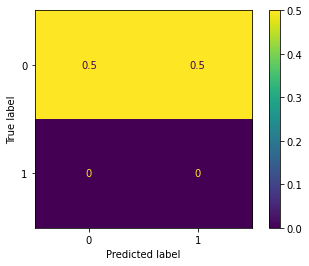

ACCURACY 0.5
Validation -- IOU:  0.6792512775711436  ACCURACY: 0.788535  F1:  0.10882276012589495


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: ignored

In [ ]:
model = MultiHeadedModel().cuda()
model
training_loop(train_dataset, val_dataset, model)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
print((dataset[0]['radiograph'][0] - dataset[0]['radiograph'][0]).max())


In [ ]:
# Visualize predictions
to_pil = torchvision.transforms.ToPILImage()
def display_mask(mask):
  mask = (mask > 0.5).float()
  return to_pil(mask[1].unsqueeze(0))

In [ ]:
# Display predicted result for first radiograph
model.eval()
mask = model(dataset[300]['radiograph'].unsqueeze(0).cuda())['out']
display_mask(mask.squeeze())

In [ ]:
# Display ground truth
import random
idx = random.randrange(0, 1000)
print(idx)
display_mask(dataset[300]['teeth_mask'])

```teeth_bbox.json```: Contains bounding box and label for each tooth. \\
```teeth_polygon.json```: Contains bounding box, label, and list of polygons for each point. 
```Segmentation/teeth_mask```: Contains a mask for where teeth are. Teeth aren't labeled though. 
